
# View Lucid Dreaming Core Session Data

This notebook loads and visualizes data recorded by the `app/main.py` application.
It reads the `session_metadata.npz` file for session information and then loads the corresponding
`eeg_eog_data.dat` and `aux_sensor_data.dat` binary files.


In [100]:

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from frenztoolkit.reader import load_experiment

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics


In [101]:

# --- Configuration & Session Selection ---
BASE_RECORDING_FOLDER = "app/recorded_data"
METADATA_FILENAME = "session_metadata.npz"
EEG_EOG_DATA_FILENAME = "eeg_eog_data.dat"
AUX_SENSOR_DATA_FILENAME = "aux_sensor_data.dat"
EEG_DATA_TYPE = np.float32 # Should match what's in main.py

def list_session_folders(base_folder):
    if not os.path.isdir(base_folder):
        print(f"Error: Base recording folder not found: {base_folder}")
        return []
    sessions = sorted([d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))], reverse=True)
    return sessions

available_sessions = list_session_folders(BASE_RECORDING_FOLDER)
if not available_sessions:
    print(f"No session folders found in {BASE_RECORDING_FOLDER}")
else:
    print("Available sessions:")
    for i, session_id in enumerate(available_sessions):
        print(f"{i}: {session_id}")
    
    # Select a session (e.g., the latest one)
    selected_session_index = 0 # Or use input() for user to choose
    if 0 <= selected_session_index < len(available_sessions):
        SESSION_FOLDER_NAME = available_sessions[selected_session_index]
        SESSION_PATH = os.path.join(BASE_RECORDING_FOLDER, SESSION_FOLDER_NAME)
        print(f"\nSelected session: {SESSION_FOLDER_NAME}")
        print(f"Session path: {SESSION_PATH}")
    else:
        print("Invalid session index selected.")
        SESSION_PATH = None

Available sessions:
0: 20250521_001132_133620
1: 20250521_000943_062030
2: 20250521_000432_485273

Selected session: 20250521_001132_133620
Session path: app/recorded_data/20250521_001132_133620


In [102]:

# --- Load Metadata --- 
metadata = None
if SESSION_PATH and os.path.isdir(SESSION_PATH):
    metadata_filepath = os.path.join(SESSION_PATH, METADATA_FILENAME)
    if os.path.exists(metadata_filepath):
        try:
            metadata = np.load(metadata_filepath, allow_pickle=True)
            print("\n--- Session Metadata ---")
            for key, value in metadata.items():
                if key not in ['scores', 'eeg_eog_data_info', 'aux_sensor_data_info'] and not key.startswith("metadata_"):
                    print(f"{key}: {value}")
            
            if 'eeg_eog_data_info' in metadata:
                print("\nEEG/EOG Data Info:")
                for k,v in metadata['eeg_eog_data_info'].item().items(): # .item() if it's a 0-d array object
                    print(f"  {k}: {v}")
            if 'aux_sensor_data_info' in metadata:
                print("\nAuxiliary Sensor Data Info:")
                for k,v in metadata['aux_sensor_data_info'].item().items():
                    print(f"  {k}: {v}")
            
            # Store for later use
            eeg_eog_info = metadata['eeg_eog_data_info'].item() if 'eeg_eog_data_info' in metadata else None
            aux_info = metadata['aux_sensor_data_info'].item() if 'aux_sensor_data_info' in metadata else None
            sampling_frequency = metadata['sampling_frequency_hz'].item() if 'sampling_frequency_hz' in metadata else 250.0

        except Exception as e:
            print(f"Error loading metadata file {metadata_filepath}: {e}")
            metadata = None
    else:
        print(f"Metadata file not found: {metadata_filepath}")
else:
    print("Session path not set or invalid.")



--- Session Metadata ---
product_key: RUtYA4W3kpXi0i9C7VZCQJY5_GRhm4XL2rKp6cviwQI=
device_id: FRENZI40
session_start_iso: 2025-05-21T00:11:32.133620
sampling_frequency_hz: 125.0

EEG/EOG Data Info:
  filename: eeg_eog_data.dat
  data_type: float32
  channel_names: ['RAW_EEG_LF', 'RAW_EEG_OTEL', 'RAW_EEG_REF1', 'RAW_EEG_RF', 'RAW_EEG_OTER', 'RAW_EEG_REF2', 'FILT_EEG_LF', 'FILT_EEG_OTEL', 'FILT_EEG_RF', 'FILT_EEG_OTER', 'FILT_EOG_CH1', 'FILT_EOG_CH2', 'FILT_EOG_CH3', 'FILT_EOG_CH4']
  num_channels: 14
  shape_on_save: channels_first

Auxiliary Sensor Data Info:
  filename: aux_sensor_data.dat
  data_type: float32
  channel_names: ['FILT_EMG_CH1', 'FILT_EMG_CH2', 'FILT_EMG_CH3', 'FILT_EMG_CH4', 'RAW_IMU_X', 'RAW_IMU_Y', 'RAW_IMU_Z', 'RAW_PPG_GREEN', 'RAW_PPG_RED', 'RAW_PPG_IR']
  num_channels: 10
  shape_on_save: channels_first


In [103]:

# --- Function to Load .dat Files ---
def load_dat_file(filepath, num_channels, total_samples, dtype=np.float32):
    if not os.path.exists(filepath):
        print(f"Data file not found: {filepath}")
        return None
    try:
        data_flat = np.fromfile(filepath, dtype=dtype)
        # Expected number of elements
        expected_elements = num_channels * total_samples
        if data_flat.size != expected_elements:
            print(f"Warning: File size mismatch for {filepath}. Expected {expected_elements} elements, got {data_flat.size}.")
            # Attempt to reshape with actual elements, might lead to incorrect total_samples if file is corrupt/incomplete
            # For robust handling, one might need to adjust total_samples or num_channels based on data_flat.size
            # For now, we'll try to reshape with the number of samples that fits the channel count
            if data_flat.size % num_channels == 0:
                actual_total_samples = data_flat.size // num_channels
                if actual_total_samples != total_samples:
                    print(f"Adjusting total samples for {filepath} from {total_samples} to {actual_total_samples} based on file size.")
                total_samples = actual_total_samples
            else:
                print(f"Error: Cannot reshape data for {filepath} as size {data_flat.size} is not divisible by num_channels {num_channels}.")
                return None
        
        # Reshape to (num_channels, total_samples)
        # Data was written as (channels, samples_in_block).tobytes(), so it's C-contiguous.
        reshaped_data = data_flat.reshape(num_channels, total_samples)
        return reshaped_data
    except Exception as e:
        print(f"Error loading or reshaping data file {filepath}: {e}")
        return None


In [104]:

# --- Load EEG/EOG Data ---
eeg_eog_data_loaded = None
if metadata and eeg_eog_info and SESSION_PATH:
    eeg_eog_data_filepath = os.path.join(SESSION_PATH, EEG_EOG_DATA_FILENAME)
    num_eeg_eog_channels = eeg_eog_info['num_channels']
    
    if 'metadata_eeg_eog_sample_counts' in metadata:
        total_eeg_eog_samples = np.sum(metadata['metadata_eeg_eog_sample_counts'])
        if total_eeg_eog_samples > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, total_eeg_eog_samples, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(eeg_eog_data_filepath)
        expected_elements = file_size // (num_eeg_eog_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
        else:
            print("EEG/EOG sample counts not found in metadata.")


File size: 77462000 bytes, expected elements: 1383250

Loaded EEG/EOG data. Shape: (14, 1383250)


In [105]:
# --- Print First 5 Rows of EEG/EOG Data ---
if eeg_eog_data_loaded is not None:
    print("First 5 rows of EEG/EOG data (channels x samples):")
    print(eeg_eog_data_loaded[:4, :])
else:
    print("EEG/EOG data not loaded.")


First 5 rows of EEG/EOG data (channels x samples):
[[ 5.6550000e+03  5.5750000e+03  5.6450000e+03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.8836622e+00  6.0716206e-01  3.7366433e+00 ...  6.2920456e+00
   6.0590878e+00  4.9277105e+00]
 [ 1.2889283e+00  1.0186682e+00  4.6600932e-01 ... -1.8059000e+04
  -1.8054000e+04 -1.8058000e+04]
 [ 1.5261100e+05  1.5218700e+05  1.5258400e+05 ... -5.5590975e-01
  -5.6171376e-01 -5.8095491e-01]]


In [106]:

# --- Load Auxiliary Sensor Data ---
aux_data_loaded = None
if metadata and aux_info and SESSION_PATH:
    aux_data_filepath = os.path.join(SESSION_PATH, AUX_SENSOR_DATA_FILENAME)
    num_aux_channels = aux_info['num_channels']
    
    if 'metadata_aux_sample_counts' in metadata:
        total_aux_samples = np.sum(metadata['metadata_aux_sample_counts'])
        if total_aux_samples > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, total_aux_samples, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("No Auxiliary sensor samples recorded according to metadata.")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(aux_data_filepath)
        expected_elements = file_size // (num_aux_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("Auxiliary sensor sample counts not found in metadata.")


File size: 55330000 bytes, expected elements: 1383250

Loaded Auxiliary sensor data. Shape: (10, 1383250)


In [107]:
# --- Print First 5 Rows of Auxiliary Sensor Data ---
if aux_data_loaded is not None:
    print("First 5 rows of Auxiliary sensor data (channels x samples):")
    print(aux_data_loaded[:5, :])
else:
    print("Auxiliary sensor data not loaded.")


First 5 rows of Auxiliary sensor data (channels x samples):
[[-1.5255341e+01 -1.7700804e+01 -4.9470348e+00 ... -2.5939374e+02
  -2.5311563e+02 -2.5571875e+02]
 [ 5.7728125e+02  5.7682190e+02  5.7728125e+02 ...  2.8134912e-01
  -4.7442231e-02 -5.0683779e-01]
 [-7.1758957e+00 -1.1086590e+00 -3.0496933e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.2062900e+05  1.2060000e+05  1.2060600e+05 ...  6.6905636e-01
  -7.9001926e-02  5.7973844e-01]
 [ 1.9584688e+02  1.9064062e+02  1.9293750e+02 ...  2.1701300e+05
   2.1705600e+05  2.1709600e+05]]


Loading session data from: app/recorded_data/20250521_001132_133620/1747800697.814435

--- Session Data Keys ---
DATA
SCORE


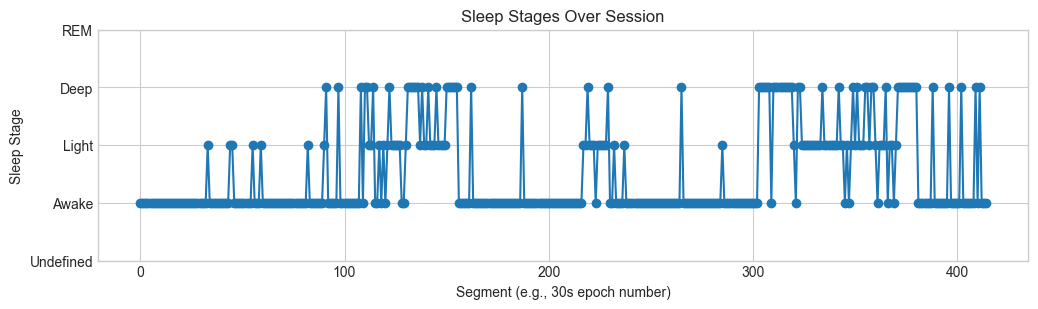

In [108]:

# --- Display Scores ---
if metadata and 'scores' in metadata:
    scores_dict = metadata['scores'].item() # .item() because it's saved as a 0-d object array containing the dict
    print("\n--- Saved Scores ---")
    for score_name, score_array in scores_dict.items():
        print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'})")
        print(score_array)
        
        # Example: Plot sleep stage if available and not empty
        if score_name == "array__sleep_stage" and hasattr(score_array, '__len__') and len(score_array) > 0:
            plt.figure(figsize=(12, 3))
            # Assuming scores are roughly every 30s for sleep stage, create a simple x-axis
            # For more accuracy, one would need timestamps per score point if available
            score_time_axis = np.arange(len(score_array))
            plt.plot(score_time_axis, score_array, marker='o', linestyle='-')
            plt.title("Sleep Stages Over Session")
            plt.xlabel("Segment (e.g., 30s epoch number)")
            plt.ylabel("Sleep Stage")
            # value < 0: undefined, value = 0: awake, value = 1: light, value = 2: deep, value = 3: REM
            plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
            plt.grid(True)
            plt.show()
else:
    # Fallback to frenztoolkit for loading session data
    # Their data is stored in a subfolder of our recorded_data folder
    # so load the experiment from the subfolder
    # Get path to first folder within the selected session
    # using os.path.isdir
    session_subfolder = os.path.join(SESSION_PATH, [d for d in os.listdir(SESSION_PATH) if os.path.isdir(os.path.join(SESSION_PATH, d))][0])
    print(f"Loading session data from: {session_subfolder}")
    # Load session data
    session_data = load_experiment(session_subfolder)
    # Print session data keys
    print("\n--- Session Data Keys ---")
    for key in session_data.keys():
        print(key)

    # Access EEG and Focus score history
    # eeg = session_data["DATA"]["RAW"]["EEG"]
    # print(eeg.shape)
    sleep_stage_list = session_data["SCORE"]["array__sleep_stage"]

    # Plot sleep stage if available
    if sleep_stage_list is not None and len(sleep_stage_list) > 0:
        plt.figure(figsize=(12, 3))
        # Assuming scores are roughly every 30s for sleep stage, create a simple x-axis
        # For more accuracy, one would need timestamps per score point if available
        score_time_axis = np.arange(len(sleep_stage_list))
        plt.plot(score_time_axis, sleep_stage_list, marker='o', linestyle='-')
        plt.title("Sleep Stages Over Session")
        plt.xlabel("Segment (e.g., 30s epoch number)")
        plt.ylabel("Sleep Stage")
        # value < 0: undefined, value = 0: awake, value = 1: light, value = 2: deep, value = 3: REM
        plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
        plt.grid(True)
        plt.show()
    else:
        print("No sleep stage data available in session data.")